In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from scipy.stats import pearsonr
import math,pickle
import itertools
import glob, os
from subprocess import Popen, PIPE
import PIL
import numpy as np
import tifffile as tiff
import scipy.signal 
import scipy.linalg
sns.set_context('notebook')
sns.set_style('ticks')
%matplotlib inline
s="""0.00025699
0.00850739
0.06541583
0.0784609 
0.07641301
0.06659586
0.05790289
0.04679429
0.02320798
0.01445644
0.00695772
0.00526551
0.002995  
0.0019852 
0.00128512
0.00134175
0.00040317
0
"""
GCaMP6s = np.array(s.replace("[","").replace("]","").split(),dtype=float)

def axcov(data, maxlag=5):
    """
    Compute the autocovariance of data at lag = -maxlag:0:maxlag
    Parameters
    ----------
    data : array
        Array containing fluorescence data
    maxlag : int
        Number of lags to use in autocovariance calculation
    Returns
    -------
    axcov : array
        Autocovariances computed from -maxlag:0:maxlag
    """
    
    data = data - np.mean(data)
    T = len(data)
    bins = np.size(data)
    xcov = np.fft.fft(data, np.power(2, nextpow2(2 * bins - 1)))
    xcov = np.fft.ifft(np.square(np.abs(xcov)))
    xcov = np.concatenate([xcov[np.arange(xcov.size - maxlag, xcov.size)],
                           xcov[np.arange(0, maxlag + 1)]])
    #xcov = xcov/np.concatenate([np.arange(T-maxlag,T+1),np.arange(T-1,T-maxlag-1,-1)])
    return np.real(xcov/T)
    
def nextpow2(value):
    """
    Find exponent such that 2^exponent is equal to or greater than abs(value).
    Parameters
    ----------
    value : int
    Returns
    -------
    exponent : int
    """
    
    exponent = 0
    avalue = np.abs(value)
    while avalue > np.power(2, exponent):
        exponent += 1
    return exponent        

def estimate_time_constant(fluor, p = 2, sn = None, lags = 5, fudge_factor = 1.):
    """    
    Estimate AR model parameters through the autocovariance function    
    Inputs
    ----------
    fluor        : nparray
        One dimensional array containing the fluorescence intensities with
        one entry per time-bin.
    p            : positive integer
        order of AR system  
    sn           : float
        noise standard deviation, estimated if not provided.
    lags         : positive integer
        number of additional lags where he autocovariance is computed
    fudge_factor : float (0< fudge_factor <= 1)
        shrinkage factor to reduce bias
        
    Return
    -----------
    g       : estimated coefficients of the AR process
    """    
    

    if sn is None:
        sn = GetSn(fluor)
        
    lags += p
    xc = axcov(fluor,lags)        
    xc = xc[:,np.newaxis]
    
    A = scipy.linalg.toeplitz(xc[lags+np.arange(lags)],xc[lags+np.arange(p)]) - sn**2*np.eye(lags,p)
    g = np.linalg.lstsq(A,xc[lags+1:])[0]
    gr = np.roots(np.concatenate([np.array([1]),-g.flatten()]))
    gr = (gr+gr.conjugate())/2.
    gr[gr>1] = 0.95 + np.random.normal(0,0.01,np.sum(gr>1))
    gr[gr<0] = 0.15 + np.random.normal(0,0.01,np.sum(gr<0))
    g = np.poly(fudge_factor*gr)
    g = -g[1:]    
        
    return g.flatten()
    

def estimate_parameters(fluor, p = 2, sn = None, g = None, range_ff = [0.25,0.5], method = 'logmexp', lags = 5, fudge_factor = 1):
    """
    Estimate noise standard deviation and AR coefficients if they are not present
    p: positive integer
        order of AR system  
    sn: float
        noise standard deviation, estimated if not provided.
    lags: positive integer
        number of additional lags where he autocovariance is computed
    range_ff : (1,2) array, nonnegative, max value <= 0.5
        range of frequency (x Nyquist rate) over which the spectrum is averaged  
    method: string
        method of averaging: Mean, median, exponentiated mean of logvalues (default)
    fudge_factor: float (0< fudge_factor <= 1)
        shrinkage factor to reduce bias
    """
    
    if sn is None:
        sn = GetSn(fluor,range_ff,method)
        
    if g is None:
        if p == 0:
            g = np.array(0)
        else:
            g = estimate_time_constant(fluor,p,sn,lags,fudge_factor)

    return g,sn

def GetSn(fluor, range_ff = [0.25,0.5], method = 'logmexp'):
    """    
    Estimate noise power through the power spectral density over the range of large frequencies    
    Inputs
    ----------
    fluor    : nparray
        One dimensional array containing the fluorescence intensities with
        one entry per time-bin.
    range_ff : (1,2) array, nonnegative, max value <= 0.5
        range of frequency (x Nyquist rate) over which the spectrum is averaged  
    method   : string
        method of averaging: Mean, median, exponentiated mean of logvalues (default)
        
    Return
    -----------
    sn       : noise standard deviation
    """
    

    ff, Pxx = scipy.signal.welch(fluor)
    ind1 = ff > range_ff[0]
    ind2 = ff < range_ff[1]
    ind = np.logical_and(ind1,ind2)
    Pxx_ind = Pxx[ind]
    sn = {
        'mean': lambda Pxx_ind: np.sqrt(np.mean(Pxx_ind/2)),
        'median': lambda Pxx_ind: np.sqrt(np.median(Pxx_ind/2)),
        'logmexp': lambda Pxx_ind: np.sqrt(np.exp(np.mean(np.log(Pxx_ind/2))))
    }[method](Pxx_ind)

    return sn


def cvxpy_foopsi(fluor,  g=None, sn=None, b=None, c1=None, bas_nonneg=True,solvers=None):
    '''Solves the deconvolution problem using the cvxpy package and the ECOS/SCS library. 
    Parameters:
    -----------
    fluor: ndarray
        fluorescence trace 
    g: list of doubles
        parameters of the autoregressive model, cardinality equivalent to p        
    sn: double
        estimated noise level
    b: double
        baseline level. If None it is estimated. 
    c1: double
        initial value of calcium. If None it is estimated.  
    bas_nonneg: boolean
        should the baseline be estimated        
    solvers: tuple of two strings
        primary and secondary solvers to be used. Can be choosen between ECOS, SCS, CVXOPT    
    Returns:
    --------
    c: estimated calcium trace
    b: estimated baseline
    c1: esimtated initial calcium value
    g: esitmated parameters of the autoregressive model
    sn: estimated noise level
    sp: estimated spikes 
        
    '''
    if g is None or sn is None:        
        g,sn = estimate_parameters(fluor, p=2, sn=sn, g = g, range_ff=noise_range, method=noise_method, lags=lags, fudge_factor=1)
    try:
        import cvxpy as cvx
    except ImportError:
        raise ImportError('cvxpy solver requires installation of cvxpy.')
    if solvers is None:
        solvers=['ECOS','SCS']
        
    T = fluor.size
    
    # construct deconvolution matrix  (sp = G*c)     
    G=scipy.sparse.dia_matrix((np.ones((1,T)),[0]),(T,T))
    
    for i,gi in enumerate(g):
        G = G + scipy.sparse.dia_matrix((-gi*np.ones((1,T)),[-1-i]),(T,T))
        
    gr = np.roots(np.concatenate([np.array([1]),-g.flatten()])) 
    gd_vec = np.max(gr)**np.arange(T)  # decay vector for initial fluorescence
    gen_vec = G.dot(scipy.sparse.coo_matrix(np.ones((T,1))))                          
 
    c = cvx.Variable(T) # calcium at each time step
    constraints=[]
    cnt = 0
    if b is None:
        flag_b = True
        cnt += 1
        b =  cvx.Variable(1) # baseline value
        if bas_nonneg:
            b_lb = 0
        else:
            b_lb = np.min(fluor)            
        constraints.append(b >= b_lb)
    else:
        flag_b = False

    if c1 is None:
        flag_c1 = True
        cnt += 1
        c1 =  cvx.Variable(1) # baseline value
        constraints.append(c1 >= 0)
    else:
        flag_c1 = False    
    
    thrNoise=sn * np.sqrt(fluor.size)
    
    try:
        objective=cvx.Minimize(cvx.norm(G*c,1)) # minimize number of spikes
        constraints.append(G*c >= 0)
        constraints.append(cvx.norm(-c + fluor - b - gd_vec*c1, 2) <= thrNoise) # constraints
        prob = cvx.Problem(objective, constraints) 
        result = prob.solve(solver=solvers[0])    
        
        if  not (prob.status ==  'optimal' or prob.status == 'optimal_inaccurate'):
            raise ValueError('Problem solved suboptimally or unfeasible')            
        
#         print 'PROBLEM STATUS:' + prob.status 
#         sys.stdout.flush()
    except (ValueError,cvx.SolverError) as err:     # if solvers fail to solve the problem           
#          print(err) 
#          sys.stdout.flush()
         lam=sn/500;
         constraints=constraints[:-1]
         objective = cvx.Minimize(cvx.norm(-c + fluor - b - gd_vec*c1, 2)+lam*cvx.norm(G*c,1))
         prob = cvx.Problem(objective, constraints)
         try: #in case scs was not installed properly
             try:
#                  print('TRYING AGAIN ECOS') 
#                  sys.stdout.flush()
                 result = prob.solve(solver=solvers[0]) 
             except:
                 result = prob.solve(solver=solvers[1]) 
         except:             
#              sys.stderr.write('***** SCS solver failed, try installing and compiling SCS for much faster performance. Otherwise set the solvers in tempora_params to ["ECOS","CVXOPT"]')
#              sys.stderr.flush()
             result = prob.solve(solver='CVXOPT')
             raise
             
         if not (prob.status ==  'optimal' or prob.status == 'optimal_inaccurate'):
#             print 'PROBLEM STATUS:' + prob.status 
            raise Exception('Problem could not be solved')
            
    
    
    sp = np.squeeze(np.asarray(G*c.value))    
    c = np.squeeze(np.asarray(c.value))                
    if flag_b:    
        b = np.squeeze(b.value)        
    if flag_c1:    
        c1 = np.squeeze(c1.value)
        
    return c,b,c1,g,sn,sp

In [2]:
directory='GCaMP6f_MidForebrain'
savedirectory='GCaMP6f_MidForebrain/results'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('G'):
        if filename.endswith('tif\n'):
            filelist.append(filename.rstrip('\n'))

In [6]:
thunder

NameError: name 'thunder' is not defined

In [3]:
import pickle
counter=-1
dict_allindex=dict.fromkeys(filelist, 0)
for i,filename in enumerate(filelist):         
    Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
    Mask=np.asarray(Mask,dtype=np.int64)    
    for value in xrange(0,Mask.max()+1):
        size=(Mask==value).sum()
        if 8 < size < 200:
            Mask[Mask==value]=counter
            counter=counter-1
        else:
            Mask[Mask==value]=0
    Mask=np.absolute(Mask)
    Mask.astype(np.uint32)
    tiff.imsave('/mnt/downloads/'+savedirectory+'/Maskb_'+filename, Mask)
    MeanFluo_ROI_thund = tsc.loadImages('/mnt/downloads/'+directory+'/'+filename, inputFormat='tif',nplanes=1,npartitions=10000)
    MeanFluo_ROI_thund=MeanFluo_ROI_thund.toTimeSeries(size='32M')
    MeanFluo_ROI_thund.cache()
    MeanFluo_ROI_thund=MeanFluo_ROI_thund.meanByRegions(Mask).detrend(method='nonlin')
    MeanFluo_ROI=MeanFluo_ROI_thund.collectAsArray()
    Centroids=MeanFluo_ROI[0]
    MeanFluo_ROI=MeanFluo_ROI[1]
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-FluoTraces-Maskb.mat', mdict={'Centroids':Centroids,'FluoTraces':MeanFluo_ROI}, oned_as='column')
    if i==0 :
        Centroids_ROI=Centroids
        SegmentData=MeanFluo_ROI
        dict_allindex[filename]=SegmentData.shape[0]
    else:
        Centroids_ROI=np.concatenate((Centroids_ROI,Centroids),axis=0)
        SegmentData=np.concatenate((SegmentData,MeanFluo_ROI),axis=0)
        dict_allindex[filename]=SegmentData.shape[0]
    if MeanFluo_ROI.shape[0]+1 != np.unique(Mask).shape[0]:
        print "there was an error with the ROIs"
        break
    if np.absolute(counter+1) != SegmentData.shape[0]:
        print "there was an error with the counter"
        break

NameError: name 'tsc' is not defined

In [ ]:
MeanFluo_ROI_thund=img.toTimeSeries(size='32M')
MeanFluo_ROI_thund.cache()
MeanFluo_ROI_thund=MeanFluo_ROI_thund.meanByRegions(Mask).detrend(method='nonlinear')
MeanFluo_ROI=MeanFluo_ROI_thund.collectAsArray()

In [16]:
MeanFluo_ROI_thund = tsc.loadImages('/mnt/downloads/'+directory+'/'+filename, inputFormat='tif',nplanes=1,npartitions=10000)
MeanFluo_ROI_thund=MeanFluo_ROI_thund.toTimeSeries(size='32M')

In [21]:
MeanFluo_ROI_thund = tsc.loadImages('/mnt/downloads/'+directory+'/'+filename, inputFormat='tif',nplanes=1,npartitions=10000)
MeanFluo_ROI_thund

Images
nrecords: None (inspect to compute)
dtype: None (inspect to compute)
dims: None (inspect to compute)

In [30]:
MeanFluo_ROI_thund=MeanFluo_ROI_thund.toTimeSeries(size='32M')
MeanFluo_ROI_thund.nrecords

6546

In [11]:
SegmentData.shape

(468831, 700)

In [34]:
MeanFluo_ROI_thund=MeanFluo_ROI_thund.detrend(method='nonlin')

In [ ]:
SegmentData=np.load('/mnt/downloads/GCaMP6fnogang/results/tempSegmentData.np.npy')

In [33]:
np.unique(Mask).shape

(6547,)

In [ ]:
tsc._sc._conf.getAll()

In [ ]:
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+directory+'-FluoTraces-Maskb.mat', mdict={'Centroids':Centroids_ROI,'FluoTraces':SegmentData}, oned_as='column')
with open('/mnt/downloads/'+savedirectory+'/'+directory+'-dict_allindex.pickle', 'w') as handle:
      pickle.dump(dict_allindex, handle)    
filelist=np.zeros(len(dict_allindex.keys()),dtype=np.object)
values=np.zeros(len(dict_allindex.keys()),dtype=int)
i=0
for key in sorted(dict_allindex):
    filelist[i]=key
    values[i]=dict_allindex[key]
    i=i+1
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+directory+'-dict_allindex_Maskb.mat',mdict={'files':filelist,'index':values}, oned_as='column')

In [ ]:
SegmentData=np.transpose(SegmentData)
corr=np.zeros(SegmentData.shape[0])
for x in xrange(0,SegmentData.shape[0]):
    for y in xrange(0,SegmentData.shape[1]-GCaMP6s.shape[0]):
        temp=SegmentData[x,y:y+GCaMP6s.shape[0]]
        temp=np.corrcoef(temp,GCaMP6s)
        if temp[0,1]>corr[x]:
            corr[x]=temp[0,1]
temp=corr>0.8
SelectData=SegmentData[temp]
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/Select'+directory+'_Corr.mat', mdict={'Fluo_select':SelectData,'Index_Select':temp}, oned_as='column')

In [148]:
def constrained_foopsi_parallel(fluor):
    cc_,cb_,c1_,gn_,sn_,sp_ = cvxpy_foopsi(fluor)
    return cc_,cb_,c1_,gn_,sn_,sp_
from joblib import Parallel,delayed
noise_method = 'logmexp'
noise_range = [.25,.5]
pool = Parallel(n_jobs=11, verbose=2)
lags = 5 
fudge_factor = 1

In [160]:
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/Select'+directory+'_oopsi-detrendlinear.mat', mdict={'Sp_infer':sp_,'Ca_infer':cc_,'baseline_infer':cb_,'Ca_init':c1_,'Params_est':gn_,'Noise':sn_}, oned_as='column')

In [ ]:
SegmentData=scipy.io.loadmat()

In [ ]:
#SegmentData=np.transpose(SegmentData)
import scipy.io
results = pool(delayed(constrained_foopsi_parallel)(rr) for rr in SegmentData)
cc_,cb_,c1_,gn_,sn_,sp_ = zip(*results)
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/Select'+directory+'_oopsi-detrendlinear.mat', mdict={'Sp_infer':sp_,'Ca_infer':cc_,'baseline_infer':cb_,'Ca_init':c1_,'Params_est':gn_,'Noise':sn_}, oned_as='column')

In [12]:
aud8freq=np.zeros((8,700),dtype=np.float16);
aud8freq[0,21:21+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[0,407:407+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[0,612:612+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[1,47:47+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[1,382:382+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[1,532:532+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[2,71:71+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[2,356:356+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[2,507:507+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[3,96:96+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[3,331:331+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[3,557:557+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[4,121:121+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[4,308:308+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[4,487:487+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[5,146:146+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[5,281:281+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[5,586:586+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[6,175:175+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[6,256:256+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[6,461:461+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[7,200:200+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[7,231:231+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[7,636:636+GCaMP6s.shape[0]]=GCaMP6s;

row,col=np.where(aud8freq==0.00850739000000000)
corr=np.zeros(SegmentData.shape[0])
for x in enumerate(SegmentData):
    for y in col:
        for z in xrange(-3,6):
            w=y+z;
            temp=x[1][w:w+GCaMP6s.shape[0]]
            temp=np.corrcoef(temp,GCaMP6s)
            if temp[0,1]>0.75:
                corr[x[0]]=corr[x[0]]+1
                break
idx_corr=corr>3
SelectCorr=SegmentData[idx_corr]

In [13]:
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/GCaMP6f-midbrain-FluoTraces-Maskb-SelectStrict.mat', mdict={'SelectCorr':SelectCorr,'Nb_corr':corr}, oned_as='column')

In [3]:
SelectCorr=scipy.io.loadmat('/mnt/downloads/'+savedirectory+'/GCaMP6f-midbrain-FluoTraces-Maskb-SelectStrict.mat')
SelectCorr=SelectCorr['SelectCorr']
SelectCorr.shape

(163552, 700)

In [21]:
test=pyxmeans.XMeans(10, kmax=None, init='kmeans++', sample_percent = 0.10)
results=test.fit(SelectCorr)

RuntimeError: centroids and data should have same type.

In [31]:
import runpy
runpy.run_module(pyxmeans.benchmark)

ImportError: Loader for module pyxmeans.benchmark cannot handle module <module 'pyxmeans.benchmark' from '/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyxmeans/benchmark.pyc'>

In [4]:
SegmentData=scipy.io.loadmat('/mnt/downloads/temp/GCaMP6f2-FluoTraces-Maskb.mat')
SegmentData=SegmentData['FluoTraces']
SegmentData.shape

(670360, 700)

In [14]:
results = pool(delayed(constrained_foopsi_parallel)(rr) for rr in SegmentData)
cc_,cb_,c1_,gn_,sn_,sp_ = zip(*results)
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/GCaMP6f-midbrain-oopsi-detrend.mat', mdict={'Sp_infer':sp_,'Ca_infer':cc_,'baseline_infer':cb_,'Ca_init':c1_,'Params_est':gn_,'Noise':sn_}, oned_as='column')

NameError: name 'pool' is not defined

In [163]:
sp_=np.asarray(sp_)
sp_.shape

(65633, 655)

In [158]:
SegmentData.shape

(33931, 655)

In [13]:
SelectCorr.shape

(245882, 700)

In [14]:
scipy.io.savemat('/mnt/downloads/temp/GCaMP6f2-FluoTraces-Maskb-SelectStrict.mat', mdict={'SelectCorr':SelectCorr,'Nb_corr':corr}, oned_as='column')

In [161]:
SegmentData=scipy.io.loadmat('/mnt/downloads/Flow/results/Flow-FluoTraces-Maskb.mat')
SegmentData=SegmentData['FluoTraces']
SegmentData.shape

(65633, 655)

In [17]:
aud8freq=np.zeros((8,700),dtype=np.float16);
aud8freq[0,21:21+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[0,407:407+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[0,612:612+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[1,47:47+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[1,382:382+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[1,532:532+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[2,71:71+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[2,356:356+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[2,507:507+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[3,96:96+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[3,331:331+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[3,557:557+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[4,121:121+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[4,308:308+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[4,487:487+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[5,146:146+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[5,281:281+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[5,586:586+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[6,175:175+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[6,256:256+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[6,461:461+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[7,200:200+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[7,231:231+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[7,636:636+GCaMP6s.shape[0]]=GCaMP6s;

row,col=np.where(aud8freq==0.00850739000000000)
corr=np.zeros(SegmentData.shape[0])
for x in enumerate(SegmentData):
    for y in col:
        for z in xrange(-3,6):
            w=y+z;
            temp=x[1][w:w+GCaMP6s.shape[0]]
            temp=np.corrcoef(temp,GCaMP6s)
            if temp[0,1]>0.75:
                corr[x[0]]=corr[x[0]]+1
                break
idx_corr=corr>3
SelectCorr=SegmentData[idx_corr]

In [18]:
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/GCaMP6f-noGang-FluoTraces-Maskb-SelectStrict2.mat', mdict={'SelectCorr':SelectCorr,'Nb_corr':corr}, oned_as='column')

In [76]:
filelist

['F23_0-1.tif',
 'F23_100.tif',
 'F23_120.tif',
 'F23_140 different light focus.tif',
 'F23_140.tif',
 'F23_160.tif',
 'F23_180.tif',
 'F23_20.tif',
 'F23_200.tif',
 'F23_220.tif',
 'F23_240.tif',
 'F23_40.tif',
 'F23_60.tif',
 'F23_80.tif']

In [75]:
directory='FlowKevin'
savedirectory='FlowKevin/results'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('F'):
        if filename.endswith('tif\n'):
            filelist.append(filename.rstrip('\n'))
filelist.sort()

In [80]:
import pickle
from joblib import Parallel, delayed
counter=-1
dict_allindex=dict.fromkeys(filelist, 0)

for i,filename in enumerate(filelist):  
    Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
    Mask=np.asarray(Mask,dtype=np.int64)    
    for value in xrange(0,Mask.max()+1):
        size=(Mask==value).sum()
        if 8 < size < 200:
            Mask[Mask==value]=counter
            counter=counter-1
        else:
            Mask[Mask==value]=0
    Mask=np.absolute(Mask)
    Mask.astype(np.uint32)
    tiff.imsave('/mnt/downloads/'+savedirectory+'/Maskb_'+filename, Mask)
    MeanFluo_ROI=tiff.imread('/mnt/downloads/'+directory+'/'+filename)
    MeanFluo_ROI=MeanFluo_ROI.swapaxes(0,2).swapaxes(0,1)
    uniq=np.unique(Mask)
    meanVals=[np.mean(MeanFluo_ROI[Mask == grp],axis=0) for grp in uniq if grp != 0]
    meanVals=np.asarray(meanVals,dtype=np.uint16)
    Centroids=[Parallel(n_jobs=-1)(delayed(scipy.ndimage.measurements.center_of_mass)(Mask,Mask,index=grp) for grp in uniq if grp !=0)]
    Centroids=np.asarray(Centroids).squeeze()    
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-FluoTraces-Maskb.mat', mdict={'Centroids':Centroids,'FluoTraces':meanVals}, oned_as='column')
    if i==0 :
        Centroids_ROI=Centroids
        SegmentData=meanVals
        dict_allindex[filename]=SegmentData.shape[0]
    else:
        Centroids_ROI=np.concatenate((Centroids_ROI,Centroids),axis=0)
        SegmentData=np.concatenate((SegmentData,meanVals),axis=0)
        dict_allindex[filename]=SegmentData.shape[0]
    if meanVals.shape[0]+1 != np.unique(Mask).shape[0]:
        print "there was an error with the ROIs"
        break
    if np.absolute(counter+1) != SegmentData.shape[0]:
        print "there was an error with the counter"
        break

In [81]:
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+directory+'-FluoTraces-Maskb.mat', mdict={'Centroids':Centroids_ROI,'FluoTraces':SegmentData}, oned_as='column')
with open('/mnt/downloads/'+savedirectory+'/'+directory+'-dict_allindex.pickle', 'w') as handle:
      pickle.dump(dict_allindex, handle)    
filelist=np.zeros(len(dict_allindex.keys()),dtype=np.object)
values=np.zeros(len(dict_allindex.keys()),dtype=int)
i=0
for key in sorted(dict_allindex):
    filelist[i]=key
    values[i]=dict_allindex[key]
    i=i+1
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+directory+'-dict_allindex_Maskb.mat',mdict={'files':filelist,'index':values}, oned_as='column')

In [54]:
MeanFluo_ROI_thund.dims

Dimensions(values=[(0, 0), (1521, 2363)], n=2)

In [8]:
test=tiff.imread('/mnt/downloads/'+directory+'/'+filename)

In [9]:
Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)

In [40]:
uniq=np.unique(Mask)
meanVals = [np.mean(test[Mask == grp],axis=0) for grp in uniq if grp != 0]
meanVals=np.asarray(meanVals,dtype=np.uint16)

In [44]:
meanVals=np.asarray(meanVals,dtype=np.uint16)

In [12]:
Mask=np.asarray(Mask,dtype=np.int64) 
Mask.shape

(1180, 1992)

In [94]:
meanVals.shape

(7757, 655)

In [78]:
from thunder.rdds.fileio.imagesloader import ImagesLoader

In [92]:
test=tiff.imread('/mnt/downloads/'+directory+'/'+filename)

In [93]:
test=test.swapaxes(0,2).swapaxes(0,1)
test.shape

(1180, 1992, 655)

In [90]:
test.shape

(655, 1180, 1992)

In [52]:
temp=scipy.ndimage.measurements.center_of_mass(Mask,Mask)

In [68]:
centroids=[scipy.ndimage.measurements.center_of_mass(Mask,Mask,index=grp) for grp in uniq if grp !=0]

In [69]:
centroids=np.asarray(centroids)
centroids.shape

(7757, 2)

In [67]:
scipy.ndimage.measurements.center_of_mass(Mask,Mask,index=5)

(167.35039370078741, 707.73228346456688)

In [71]:
from joblib import Parallel, delayed
centroids=[Parallel(n_jobs=-1)(delayed(scipy.ndimage.measurements.center_of_mass)(Mask,Mask,index=grp) for grp in uniq if grp !=0)]
centroids=np.asarray(centroids)
centroids.shape

(1, 7757, 2)

In [73]:
centroids=centroids.squeeze()

In [74]:
centroids

array([[  141.03389831,   596.79096045],
       [  151.67938931,   711.14503817],
       [  147.79558011,   551.58563536],
       ..., 
       [ 1159.5       ,   102.2       ],
       [ 1159.95652174,    97.82608696],
       [ 1171.59210526,    90.68421053]])

In [88]:
scipy.ndimage.measurements.center_of_mass(Mask,Mask,index=8963)

(1171.5921052631579, 90.684210526315795)

In [87]:
uniq[7757]

8963

In [11]:
import numpy as np
import random
import time
from contextlib import contextmanager
from pyxmeans import _minibatch
from pyxmeans.mini_batch import MiniBatch
from pyxmeans.xmeans import XMeans

In [12]:
try:
    import pylab as py
except ImportError:
    py = None
    print "Could not find matplotlib, not plotting"

try:
    from sklearn.cluster import MiniBatchKMeans
except ImportError:
    MiniBatchKMeans = None

In [13]:
def TimerBlock(name):
    start = time.time()
    yield
    end = time.time()
    print "%s took %fs" % (name, end-start)

def generate_data(N, D, k, sigma=0.1):
    data = np.empty((N, D))
    distributions = [{"mean" : np.random.rand(D), "cov" : np.eye(D) * np.random.rand() * sigma} for i in xrange(k)]
    for i in xrange(N):
        params = random.choice(distributions)
        data[i, :] = np.random.multivariate_normal(**params)
    return data, distributions

def error(actual, test):
    err = 0.0
    for t in test:
        v = np.square(actual - test[:, np.newaxis]).sum(axis=1).min()
        err += v
    return err / float(len(test))

In [14]:
print "Creating data"
N = 10000
D = 2
k = 32
max_iter = 100
n_samples = k * 10

data, actual = generate_data(N, D, k, sigma=0.001)
actual_data = np.asarray([x["mean"] for x in actual])
clusters = _minibatch.kmeanspp_multi(data, np.empty((k, D), dtype=np.double), N / 100, 20, 4)
print "Number of points: ", N
print "Number of dimensions: ", D
print "Number of clusters: ", k
print "initial BIC: ", _minibatch.bic(data, clusters)
print "initial variance: ", _minibatch.model_variance(data, clusters)
print "initial RMS Error: ", error(actual_data, clusters)
print

print "Clustering with single-threaded pyxmeans"
clusters_pymeans_single = clusters.copy()
start = time.time()
mbst = MiniBatch(k, n_samples=n_samples, max_iter=max_iter, n_runs=1, init=clusters_pymeans_single, n_jobs=1, compute_labels=False).fit(data)
clusters_pymeans_single = mbst.cluster_centers_
end = time.time()
print "%s took %fs" % ("singlethreaded pyxmeans", end-start)
print "BIC: ", _minibatch.bic(data, clusters_pymeans_single)
print "Variance: ", _minibatch.model_variance(data, clusters_pymeans_single)
print "RMS Error: ", error(actual_data, clusters_pymeans_single)
print

print "Clustering with multi-threaded pyxmeans"
clusters_pymeans_multi = clusters.copy()
start = time.time()
mbmt = MiniBatch(k, n_samples=n_samples, max_iter=max_iter, n_runs=4, init=clusters_pymeans_multi, n_jobs=0, compute_labels=False).fit(data)
clusters_pymeans_multi = mbmt.cluster_centers_
end = time.time()
print "%s took %fs" % ("multithreaded pyxmeans", end-start)
print "BIC: ", _minibatch.bic(data, clusters_pymeans_multi)
print "Variance: ", _minibatch.model_variance(data, clusters_pymeans_multi)
print "RMS Error: ", error(actual_data, clusters_pymeans_multi)
print

Creating data
Number of points:  10000
Number of dimensions:  2
Number of clusters:  32
initial BIC:  -50044.2578481
initial variance:  0.00139573594303
initial RMS Error:  2.35158001531

Clustering with single-threaded pyxmeans
singlethreaded pyxmeans took 0.028499s
BIC:  -50338.2237724
Variance:  0.00105476351585
RMS Error:  2.3527938245

Clustering with multi-threaded pyxmeans


/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyxmeans/mini_batch.py:109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.init == 'random':
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyxmeans/mini_batch.py:111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif self.init == 'kmeans++':


multithreaded pyxmeans took 0.617292s
BIC:  -51265.3040256
Variance:  0.00086624238556
RMS Error:  2.35146305089



In [16]:
data.dtype

dtype('float64')

Creating data
Number of points:  10000
Number of dimensions:  2
Number of clusters:  32
initial BIC:  -50442.0906635
initial variance:  0.00137363033393
initial RMS Error:  2.41538310761

Clustering with single-threaded pyxmeans
singlethreaded pyxmeans took 0.031925s
BIC:  -50677.3642854
Variance:  0.000917597526051
RMS Error:  2.40848515176

Clustering with multi-threaded pyxmeans
multithreaded pyxmeans took 0.628387s
BIC:  -50855.869743
Variance:  0.000876257248316
RMS Error:  2.40844597753

Clustering with multi-threaded pyxmeans (starting k at 20)


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

multithreaded pyxmeans k took 73.004954s
Num Clusters:  29
BIC:  -49556.6954552
Variance:  0.00103509955181
RMS Error:  2.40890053166

Clustering with sklearn


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=3


multithreaded sklearn took 6.347718s
BIC:  -50691.8265738
Variance:  0.000886504448806
RMS Error:  2.40889615744


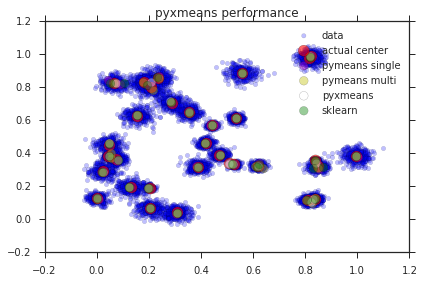

In [38]:
print "Creating data"
N = 10000
D = 2
k = 32
max_iter = 100
n_samples = k * 10

data, actual = generate_data(N, D, k, sigma=0.001)
actual_data = np.asarray([x["mean"] for x in actual])
clusters = _minibatch.kmeanspp_multi(data, np.empty((k, D), dtype=np.double), N / 100, 20, 4)
print "Number of points: ", N
print "Number of dimensions: ", D
print "Number of clusters: ", k
print "initial BIC: ", _minibatch.bic(data, clusters)
print "initial variance: ", _minibatch.model_variance(data, clusters)
print "initial RMS Error: ", error(actual_data, clusters)
print

print "Clustering with single-threaded pyxmeans"
clusters_pymeans_single = clusters.copy()
start = time.time()
mbst = MiniBatch(k, n_samples=n_samples, max_iter=max_iter, n_runs=1, init=clusters_pymeans_single, n_jobs=1, compute_labels=False).fit(data)
clusters_pymeans_single = mbst.cluster_centers_
end = time.time()
print "%s took %fs" % ("singlethreaded pyxmeans", end-start)
print "BIC: ", _minibatch.bic(data, clusters_pymeans_single)
print "Variance: ", _minibatch.model_variance(data, clusters_pymeans_single)
print "RMS Error: ", error(actual_data, clusters_pymeans_single)
print

print "Clustering with multi-threaded pyxmeans"
clusters_pymeans_multi = clusters.copy()
start = time.time()
mbmt = MiniBatch(k, n_samples=n_samples, max_iter=max_iter, n_runs=4, init=clusters_pymeans_multi, n_jobs=0, compute_labels=False).fit(data)
clusters_pymeans_multi = mbmt.cluster_centers_
end = time.time()
print "%s took %fs" % ("multithreaded pyxmeans", end-start)
print "BIC: ", _minibatch.bic(data, clusters_pymeans_multi)
print "Variance: ", _minibatch.model_variance(data, clusters_pymeans_multi)
print "RMS Error: ", error(actual_data, clusters_pymeans_multi)
print

k_init = int(k * 0.65)
print "Clustering with multi-threaded pyxmeans (starting k at {})".format(k_init)
start = time.time()
mxmt = XMeans(k_init, verbose=False).fit(data)
clusters_xmeans = mxmt.cluster_centers_
end = time.time()
print "%s took %fs" % ("multithreaded pyxmeans k", end-start)
print "Num Clusters: ", len(clusters_xmeans)
print "BIC: ", _minibatch.bic(data, clusters_xmeans)
print "Variance: ", _minibatch.model_variance(data, clusters_xmeans)
print "RMS Error: ", error(actual_data, clusters_xmeans)
print

print "Clustering with sklearn"
if MiniBatchKMeans:
    clusters_sklearn = clusters.copy()
    start = time.time()
    mbkmv = MiniBatchKMeans(k, max_iter=max_iter, batch_size=n_samples, init=clusters_sklearn, reassignment_ratio=0, compute_labels=False, max_no_improvement=None).fit(data)
    end = time.time()
    print "%s took %fs" % ("multithreaded sklearn", end-start)
    print "BIC: ", _minibatch.bic(data, mbkmv.cluster_centers_)
    print "Variance: ", _minibatch.model_variance(data, mbkmv.cluster_centers_)
    print "RMS Error: ", error(actual_data, clusters_sklearn)
else:
    print "sklearn not found"


if py is not None:
    py.figure()
    py.title("pyxmeans performance")
    py.scatter(data[:,0], data[:,1], alpha=0.25, label="data")
    py.scatter(actual_data[:,0], actual_data[:,1], c='r', s=125, alpha=0.6, label="actual center")
    py.scatter(clusters_pymeans_single[:,0], clusters_pymeans_single[:,1], c='m', s=75, alpha=0.4, label="pymeans single")
    py.scatter(clusters_pymeans_multi[:,0], clusters_pymeans_multi[:,1], c='y', s=75, alpha=0.4, label="pymeans multi")
    py.scatter(clusters_xmeans[:,0], clusters_xmeans[:,1], c='w', s=75, alpha=0.4, label="pyxmeans")
    if MiniBatchKMeans:
        py.scatter(clusters_sklearn[:,0], clusters_sklearn[:,1], s=75, c='g', alpha=0.4, label="sklearn")
    py.legend()

    py.tight_layout()
    py.show()

In [18]:
SelectCorr=np.float64(SelectCorr)

In [21]:
from pyxmeans.xmeans import XMeans
mxmt = XMeans(kmin=50, sample_percent = 0.1,verbose=True).fit(SelectCorr)

RuntimeError: data not what was expected.

In [8]:
SelectCorr=np.float32(SelectCorr)

In [22]:
len(SelectCorr)

163552

In [25]:
MiniBatchKMeans

sklearn.cluster.k_means_.MiniBatchKMeans

In [ ]:
mbmt = MiniBatch(50, n_samples=0.1*len(SelectCorr), max_iter=100, n_runs=4, init=clusters_pymeans_multi, n_jobs=0, compute_labels=False).fit(data)

In [38]:
clusters = _minibatch.kmeanspp_multi(SelectCorr, np.empty((50, 700), dtype=np.double), N / 100, 20, 4)

RuntimeError: data not what was expected.

In [26]:
mbkmv = MiniBatchKMeans(50, max_iter=100, batch_size=500).fit(SelectCorr)

In [30]:
_minibatch.bic(SelectCorr, mbkmv.cluster_centers_)

RuntimeError: data not what was expected.

In [59]:
from scipy.spatial import distance
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = kmeans.cluster_centers_
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[i]], 'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term
    

    return(BIC)


In [60]:
compute_bic(mbkmv,SelectCorr)

-791238602.91767848

In [62]:
mbkmv = MiniBatchKMeans(500, max_iter=100, batch_size=500).fit(SelectCorr)
compute_bic(mbkmv,SelectCorr)

-778978445.03911304

In [68]:
kmin=1
kmax=200
bic=np.zeros(kmax-kmin)

In [70]:
for i in xrange(kmin,kmax):
    mbkmv = MiniBatchKMeans(i, max_iter=200, batch_size=10000).fit(SelectCorr)
    bic[i]=compute_bic(mbkmv,SelectCorr)

IndexError: index 199 is out of bounds for axis 0 with size 199

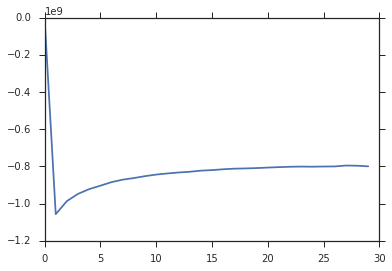

In [72]:
plt.plot(bic[:30])